# Dynamic Time Warping Example

In this notebook, we use the `dtaidistance` package to perform dynamic time warp (DTW) distance measurements of a time series against a reference set of steps. 

We will show that it can be used to identify matches when the distance is low.

In [1]:
import pandas as pd
import json
from dtaidistance import dtw
import numpy as np

Load our reference sequences.

These are stored in json in our label studio output, so will take a little wrangling. The labels give us the endpoints. We use those indexes in the time series data.

In [2]:
reference_file = 'label_studio_export/label_studio_export.json'

with open(reference_file,'r') as f:
    ref_data = json.loads(f.read())

In [6]:
ref_data[2]['annotations'][0]['result']

[{'value': {'start': 21.000197583343837,
   'end': 23.689502458350034,
   'instant': False,
   'timeserieslabels': ['Cleese']},
  'id': 'Motif 0',
  'from_name': 'label',
  'to_name': 'ts',
  'type': 'timeserieslabels',
  'origin': 'manual'},
 {'value': {'start': 33.62082974999794,
   'end': 36.30008283333154,
   'instant': False,
   'timeserieslabels': ['Cleese']},
  'id': 'Motif 1',
  'from_name': 'label',
  'to_name': 'ts',
  'type': 'timeserieslabels',
  'origin': 'manual'},
 {'value': {'start': 29.702682250004727,
   'end': 32.23084308335092,
   'instant': False,
   'timeserieslabels': ['Cleese']},
  'id': 'Motif 2',
  'from_name': 'label',
  'to_name': 'ts',
  'type': 'timeserieslabels',
  'origin': 'manual'},
 {'value': {'start': 17.24323658333742,
   'end': 19.99296758335549,
   'instant': False,
   'timeserieslabels': ['Cleese']},
  'id': 'Motif 3',
  'from_name': 'label',
  'to_name': 'ts',
  'type': 'timeserieslabels',
  'origin': 'manual'},
 {'value': {'start': 13.425847958

In [7]:
print(ref_data[0]['data']['ts']['acc'][:10])
print(ref_data[0]['data']['ts']['acc_time'][:10])

[3.7472206894862925, 2.042115844258238, 1.3841208207002393, 1.1108645827634926, 0.7322604661821435, 0.7445179491693367, 0.6283425650137454, 0.5413873322405691, 1.117704747805263, 1.6010875178705952]
[0.02481895824894309, 0.03489095834083855, 0.04496295819990337, 0.05503495829179883, 0.06510695815086365, 0.07517912494949996, 0.08525112480856478, 0.09532312490046024, 0.1053951249923557, 0.11546712485142052]


In [10]:
i = 2
annotations = ref_data[i]['annotations'][0]['result']
acc = np.array(ref_data[i]['data']['ts']['acc'])
acc_time = np.array(ref_data[i]['data']['ts']['acc_time'])

labels = []
sequences = []

for a in annotations:
    v = a['value']
    start = v['start']
    end = v['end']
    label = v['timeserieslabels'][0] # assume we just have 1 label per region

    # find the indices of start/end in the acc_time series
    start_idx, end_idx = np.where(np.isin(acc_time,[start,end]))[0]

    # store for use in dtaidistance
    labels.append(label)
    sequences.append(acc[start_idx:end_idx+1]) #adding 1 to include the final point



In [11]:
dtw.distance_matrix_fast(sequences)

array([[ 0.        , 35.25623685, 33.48976231, 46.23101593, 27.79227272,
        36.33574038],
       [35.25623685,  0.        , 30.36215447, 64.99066315, 28.10691786,
        50.09243854],
       [33.48976231, 30.36215447,  0.        , 53.88304005, 29.00534418,
        45.43454229],
       [46.23101593, 64.99066315, 53.88304005,  0.        , 59.54029795,
        30.65881026],
       [27.79227272, 28.10691786, 29.00534418, 59.54029795,  0.        ,
        42.30974766],
       [36.33574038, 50.09243854, 45.43454229, 30.65881026, 42.30974766,
         0.        ]])

Load a new sequence we want to search

In [17]:
series_df = pd.read_csv('label_studio/cleese_data_2.csv')
series = series_df.acc.to_numpy()

In [18]:
# pick a single example to query
query = sequences[0]

(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

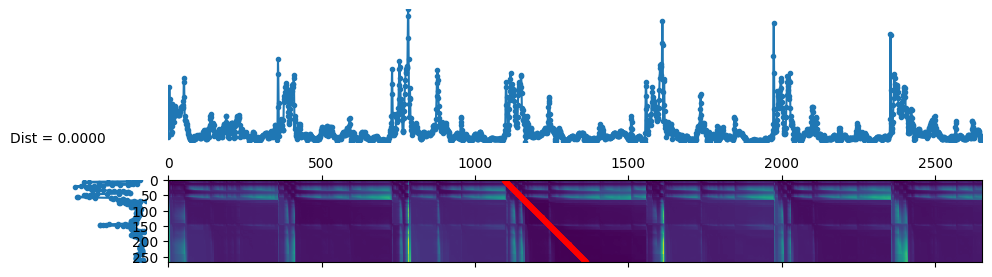

In [19]:
from dtaidistance.subsequence.dtw import subsequence_alignment
from dtaidistance import dtw_visualisation as dtwvis

sa = subsequence_alignment(query, series)
match = sa.best_match()
startidx, endidx = match.segment
dtwvis.plot_warpingpaths(query, series, sa.warping_paths(), match.path)

Distance | Value (dist. normalized by query length)
 0.00000 |  0.00000
25.80819 |  0.09630
26.62263 |  0.09934
28.29804 |  0.10559
32.96991 |  0.12302
33.77286 |  0.12602
40.49215 |  0.15109
46.54409 |  0.17367


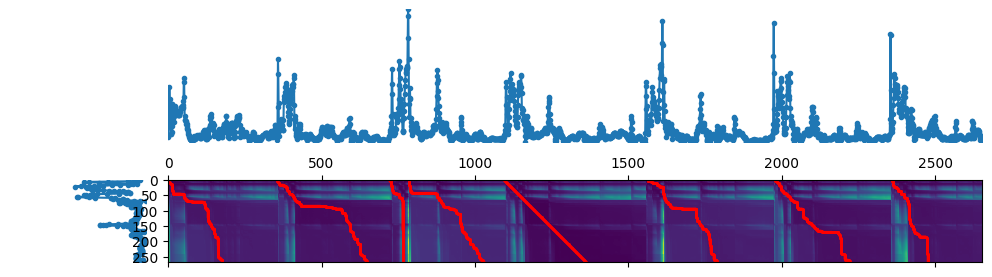

In [20]:
fig, ax = dtwvis.plot_warpingpaths(query, series, sa.warping_paths(), path=-1)
print(f'Distance | Value (dist. normalized by query length)')
for kmatch in sa.kbest_matches_fast(9):
    dtwvis.plot_warpingpaths_addpath(ax, kmatch.path)
    print(f'{kmatch.distance:8.5f} | {kmatch.value:8.5f}')

Try with another reference sequence. We'll see the exact, trivial match (diagonal line), and which ones are similar:

Distance | Value (dist. normalized by query length)
 0.00000 |  0.00000
28.09386 |  0.11148
30.07192 |  0.11933
33.16590 |  0.13161
38.09399 |  0.15117
41.78957 |  0.16583
45.07198 |  0.17886
53.70053 |  0.21310


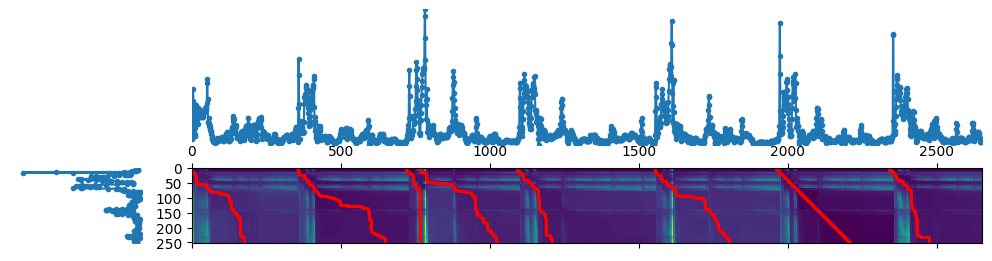

In [21]:
query = sequences[2]
sa = subsequence_alignment(query, series)
fig, ax = dtwvis.plot_warpingpaths(query, series, sa.warping_paths(), path=-1)
print(f'Distance | Value (dist. normalized by query length)')
for kmatch in sa.kbest_matches_fast(9):
    dtwvis.plot_warpingpaths_addpath(ax, kmatch.path)
    print(f'{kmatch.distance:8.5f} | {kmatch.value:8.5f}')

Try the same with a series that does not contain any of this kind of step

In [22]:
series_fwd_df = pd.read_csv('label_studio/forward_walk_data.csv')
series_fwd = series_fwd_df.acc.to_numpy()

74.27297 |  0.27714
1001
[np.int64(644), np.int64(1001)]
74.75994 |  0.27895
1577
[np.int64(1528), np.int64(1577)]
75.69303 |  0.28244
410
[np.int64(336), np.int64(410)]
83.86942 |  0.31295
306
[np.int64(229), np.int64(306)]
89.46580 |  0.33383
197
[np.int64(118), np.int64(197)]
98.60969 |  0.36795
118
[np.int64(81), np.int64(118)]
100.13789 |  0.37365
81
[np.int64(55), np.int64(81)]
108.17446 |  0.40364
55
[np.int64(0), np.int64(55)]


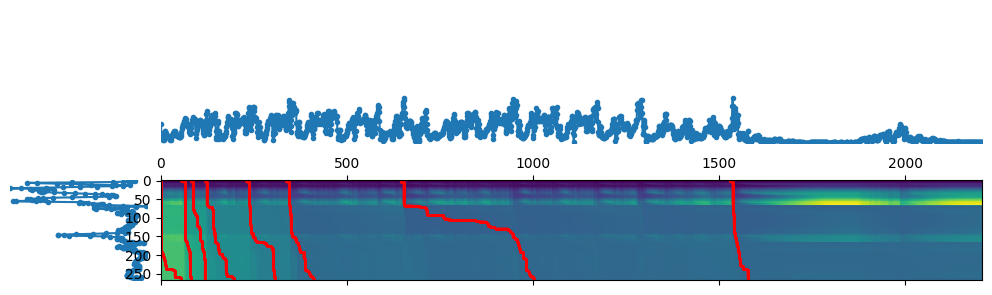

In [23]:
query = sequences[0]
sa = subsequence_alignment(query, series_fwd)
fig, ax = dtwvis.plot_warpingpaths(query, series_fwd, sa.warping_paths(), path=-1)
for kmatch in sa.kbest_matches_fast(9):
    dtwvis.plot_warpingpaths_addpath(ax, kmatch.path)
    print(f'{kmatch.distance:8.5f} | {kmatch.value:8.5f}')
    print(kmatch.idx)
    print(kmatch.segment)